In [493]:
### initialize dependencies:
! pip install opencv-python
! pip install numpy
! pip install matplotlib
! pip install numpy
! pip install tensorflow
! pip install shapely

In [494]:
### imports:
import numpy as np
import cv2 as cv
import os, json
from typing import Tuple, List
import matplotlib.pyplot as plt
import random
import tensorflow as tf

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [603]:
# please make sure the returned list is not empty
tf.config.list_physical_devices(device_type="GPU")

[]

## Define some image preprocessing
- we can change the preprocessing later in order to improve our model. The goal is mainly to capture local differences in color.

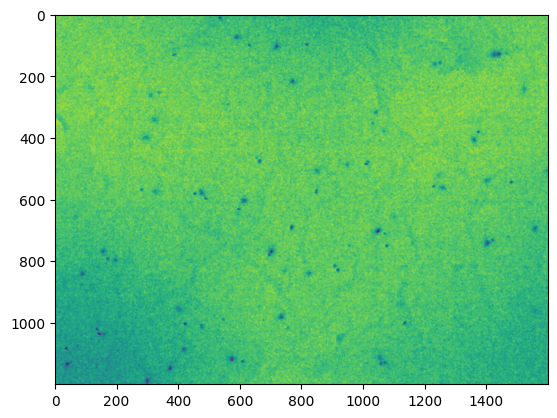

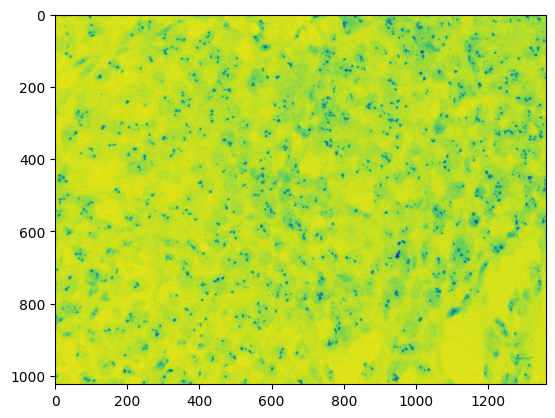

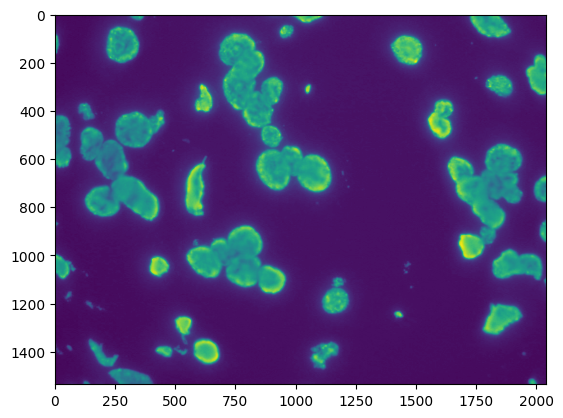

In [604]:
def image_preprocess(im):
    """the goal is to make the result agnostic to color and darkness variations"""
    return im
    # im = cv.GaussianBlur(im, (7,7), 7)
    # # convert image from bgr to hls:
    # im = cv.cvtColor(im, cv.COLOR_BGR2HLS)
    # # equalize the histogram of the value channel:
    # im[:,:,2] = cv.equalizeHist(im[:,:,2])
    # # for all 3 channels calculate sobel
    # for i in [0]:
    #     im[:,:,i] = cv.GaussianBlur(im[:,:,i], (7,7), 7)
    #     im[:,:,i] = cv.Sobel(im[:,:,i], cv.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    
    # # for the hue channel, the colors for a number ring, so for example 0 and 255 have a distance of 1. 
    # im[:,:,2] = np.abs(im[:,:,2]-127)*2 # type: ignore
    # im[:,:,2] = np.where(im[:,:,2] > 127, 256 - im[:,:,2], im[:,:,2]) # type: ignore
    # return im

for path in ["output/images/1.jpg", "output/images/2.jpg", "output/images/3.jpg"]:
    im = cv.imread(path)
    im = image_preprocess(im)
    cv.imwrite(path + ".prep.jpg", im)
    plt.imshow(im[:,:,0])
    plt.show()

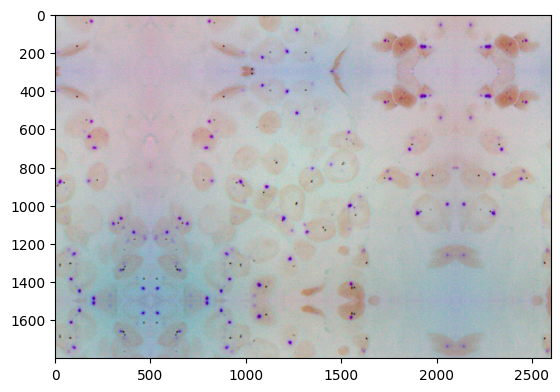

In [605]:
def apply_mirror_padding(img: cv.Mat, size: Tuple[int, int]) -> cv.Mat:
     """
     img: should be 3 dimensional
     size: extension in pixels in (y,x) directions
     """

     (h,w) = img.shape[0], img.shape[1]
     (y,x) = size
     newimg = np.zeros((h + 2*y, w + 2 *x, img.shape[2]), dtype = np.uint8)
     newimg[y:h+y,x:w+x,:] = img[:,:,:]
     newimg[0:y,0:x,:] = np.flip(np.flip(img[0:y,0:x,:], axis=1),axis=0)
     newimg[h+y:,0:x,:] = np.flip(np.flip(img[h-y:,0:x,:], axis=1),axis=0)
     newimg[0:y,w+x:,:] = np.flip(np.flip(img[0:y,w-x:,:], axis=1),axis=0)
     newimg[h+y:,w+x:,:] = np.flip(np.flip(img[h-y:,w-x:,:], axis=1),axis=0) 

     newimg[0:y,x:w+x,:] = np.flip(img[0:y,:,:], axis=0)
     newimg[y+h:,x:w+x,:] = np.flip(img[h-y:,:,:], axis=0)
     newimg[y:h+y,0:x,:] = np.flip(img[:,0:x,:], axis=1)
     newimg[y:h+y,w+x:,:] = np.flip(img[:,w-x:,:], axis=1)
     return newimg
     
im = cv.imread("output/images/1.jpg")
im = apply_mirror_padding(im, (300,500))
plt.imshow(im)

## Constants

In [606]:
TARGET_BOUNDS_LENGTH = 32
PIXEL_GRID_SIZE = 5
CONVOLUTION_FRAME_SIZE = 2*TARGET_BOUNDS_LENGTH

## Data loading and preprocessing

In [612]:
from typing import Any, Dict, Generator
from shapely.geometry import Polygon, Point, MultiPoint

class AnnotationPoly():
    """A polygon from a list of points"""
    points: List[Tuple[float, float]]
    _polygon: Polygon
    center: Tuple[float, float]
    area: float
    # (y, x) points of the surrounding
    def __init__(self,points: List[Tuple[float, float]]) -> None:
        self.points = points
        self._polygon = Polygon(self.points)

        center_point: Point = self._polygon.centroid
        self.center = (center_point.x,center_point.y)
        self.area = self._polygon.area

    @staticmethod 
    def from_json(json: Dict[str, Any]):
        xes = [float(s) for s in json["Points"][0]["X"].split(",")]
        yes = [float(s) for s in json["Points"][0]["Y"].split(",")]
        return  AnnotationPoly([ (x,y) for (x,y) in zip(xes, yes)])
        

    def bounds_size(self) -> Tuple[float, float]:
        """returns (height,width) of the area enclosed"""   
        minx, miny, maxx, maxy = self._polygon.bounds
        return (maxy-miny, maxx-minx)

    def bounds_avg_size(self):
        h,w = self.bounds_size()
        return (h+w)/2

    def contains_point(self, point: Tuple[float, float]):
        return Point(point[1], point[0]).within(self._polygon)
        # self._polygon.within()

    def resize(self, resize_factor: float):
        new_points = [(y*resize_factor, x*resize_factor) for (y,x) in self.points]
        return  AnnotationPoly(new_points)


class TrainImage():
    annotations : List[AnnotationPoly]
    resized: np.ndarray
    resized_annotations: List[AnnotationPoly]
    resize_factor: float
    name: str
    def __init__(self, partial_path: str) -> None:
        """expects partial_path to be like: "DISH1/125121A_S20200928_0014"
            - looks for data/reference/DISH1/125121A_S20200928_0014/ndmctsgh.json
            - looks for data/sampleinput/DISH1/125121A_S20200928_0014.jpg
        """
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        
        json_path = f"data/reference/{partial_path}/ndmctsgh.json"
        self.name = partial_path

        # read metadata from json
        f = open(json_path)
        j = json.load(f)
        f.close()
        annotations = []
        for a in j["annotations"]:
            annotations.append(AnnotationPoly.from_json(a))
        self.annotations = annotations
        # read image and preprocess it to form features:

        img = cv.imread(jpg_path)

        # for now not needed:
        # hist, bins = np.histogram(img.ravel(),bins=[e for e in range(256)])
        # hist = hist / np.sum(hist)
        # plt.bar(range(0,255),hist)

        # resize image such that the average bounds length of an annotation is 
        avg_bounds_length = np.mean([a.bounds_avg_size() for a in self.annotations])
        (h,w,_) = img.shape
        self.resize_factor = float(TARGET_BOUNDS_LENGTH / avg_bounds_length)
        (newh, neww) = int(self.resize_factor * h), int(self.resize_factor * w)
        self.resized = cv.resize(img, (neww, newh))
        print(f"    resized image {self.name} from {w}x{h} to {neww}x{newh}")
        self.resized_annotations = [e.resize(self.resize_factor)  for e in self.annotations]

def convolution_frames(image: cv.Mat) -> Generator[Tuple[int,int,int,int,tf.Tensor], None, None]:
    # apply mirrored padding to the resized image, such that the borders become a non-issue
    frame_size = CONVOLUTION_FRAME_SIZE
    frame_half = int(frame_size / 2)
    preprocessed_img = image_preprocess(image)
    padded_img = apply_mirror_padding(preprocessed_img, (frame_size, frame_size))
    (rh,rw) = image.shape[0], image.shape[1]
    grid_i = 0
    for i in range(0,rh,PIXEL_GRID_SIZE):
        grid_j=0
        for j in range(0,rw,PIXEL_GRID_SIZE):
            # each of these gridpoints represents on training example.
            # build convolution frame:
            pos_in_pad_y, pos_in_pad_x = frame_size + i, frame_size + j
            # this gives us a CONVOLUTION_FRAME_SIZE*CONVOLUTION_FRAME_SIZE section of the image, on which the neural network can operate.
            # because of the mirror padding we do not need to worry about the borders much.
            convolution_frame = padded_img[pos_in_pad_y-frame_half:pos_in_pad_y+frame_half,pos_in_pad_x-frame_half:pos_in_pad_x+frame_half]
            assert convolution_frame.shape == (CONVOLUTION_FRAME_SIZE,CONVOLUTION_FRAME_SIZE,3)
            convolution_frame_tensor = tf.convert_to_tensor(convolution_frame,np.float32)
            yield (i,j, grid_i, grid_j, convolution_frame_tensor)
            grid_j+=1
        grid_i+=1


im1 =TrainImage("DISH1/125121A_S20200928_0014")
        

    resized image DISH1/125121A_S20200928_0014 from 1600x1200 to 389x292


## constructing a neural net for predictions

we want to be able to predict for every 10th pixel in x and y direction.


In [615]:
all_train_images_partial_paths = [
    # "TEST/test"
    "DISH1/125121A_S20200928_0014",
    "DISH1/125121A_S20200928_0017",
    "DISH1/1931427A_S20200928_0005",
    "DISH1/1931427A_S20200928_0014",
    "DISH1/2004994A_S20201013_0001",
    "DISH2/1(2)",
    "DISH2/5(2)",
    "DISH2/DISH3",
    "DISH2/P002120277A-2",
    "DISH2/P002124864A-1",
    "FISH/12-09-12P0012201890-2",
    "FISH/12-09-12P0012201893-1",
    "FISH/12-09-13P001220195-1",
    "FISH/P001506473(P001805365A)-1",
    "FISH/P001531546(P001529027C)9",
]

class ImageDataset():
    train_images: List[TrainImage]
    def __init__(self, partial_paths : List[str] = all_train_images_partial_paths) -> None:
        print("Creating dataset...")
        self.train_images = []
        for partial_path in partial_paths:
            train_image = TrainImage(partial_path)
            self.train_images.append(train_image)
        print("Done creating dataset.")

    def to_tensorflow_dataset(self) -> tf.data.Dataset:
        INPUT_SPEC = tf.TensorSpec(shape=(CONVOLUTION_FRAME_SIZE,CONVOLUTION_FRAME_SIZE,3), dtype=tf.float32) # type: ignore #
        OUTPUT_SPEC = tf.TensorSpec(shape=(1,), dtype=tf.float32) # type: ignore #
        output_signature = (INPUT_SPEC, OUTPUT_SPEC, OUTPUT_SPEC)
        return tf.data.Dataset.from_generator(self.iter,output_signature=output_signature)

    def data_point_count(self):
        """returns the number of training examples (grid points) across all images"""
        cc = 0
        for train_img in self.train_images:
            c = 0
            (rh,rw) = train_img.resized.shape[0], train_img.resized.shape[1]
            for i in range(0,rh,PIXEL_GRID_SIZE):
                for j in range(0,rw,PIXEL_GRID_SIZE):
                    c+=1
            print(f"{train_img.name} ({rw}x{rh}) has {c} grid points")
            cc += c
        return cc

    def iter(self) -> Generator[Tuple[tf.Tensor, tf.Tensor, tf.Tensor], None, None]:
        """iterator for returning individual data objects for training"""
        for train_img in self.train_images:
            for (i,j,_,_,convolution_frame_tensor) in convolution_frames(train_img.resized):
                
                # build label. label = (in_region,center_d_y,center_d_x) (is in annotation region? , what direction to annotation center)
                contains_point = False
                # this generates noise for non-annotation-points
                center_dir = np.random.random((2,)) * [train_img.resized.shape[0], train_img.resized.shape[1]]  # as (y_dir, x_dir) a normalized 2d vector
                for a in train_img.resized_annotations:
                    if(a.contains_point((i,j))):
                        contains_point = True
                        x_dist =  j-a.center[1]
                        y_dist = i-a.center[0]
                        r = np.sqrt(x_dist*x_dist + y_dist*y_dist)
                        center_dir = [y_dist/r, x_dist/r]
                        break
                label_tensor = tf.convert_to_tensor(np.array([1.0 if contains_point else 0.0]), np.float32) # , center_dir[0], center_dir[1]
                weight_tensor = tf.convert_to_tensor(np.array([0.9 if contains_point else 0.1]), np.float32)
                yield (convolution_frame_tensor, label_tensor, weight_tensor)

dataset = ImageDataset()
tf_dataset = dataset.to_tensorflow_dataset()

Creating dataset...
    resized image DISH1/125121A_S20200928_0014 from 1600x1200 to 389x292
Done creating dataset.


## Defining the model

In [624]:
from tensorflow.python.keras.layers import Dense, Reshape, Conv2D, Dropout, MaxPool2D, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow.python.keras.metrics as metrics

output_bias = tf.keras.initializers.Constant(-4)
model = Sequential([
    Conv2D(1, 3,activation='relu', input_shape=(64, 64,3)),
    MaxPool2D(pool_size=(3,3), strides=(1,1)),
    Conv2D(1, 3, activation='relu', input_shape=(60, 60,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(1, 3, activation='relu', input_shape=(28, 28,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(1, 3, activation='relu', input_shape=(12,12,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout(0.2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid', bias_initializer=output_bias), # type: ignore
])

loss_fn = BinaryCrossentropy()

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
 
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=METRICS)

BATCH_SIZE = 512
EPOCHS = 200

checkpoint_path = "training/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0,
                                                 save_freq=1) # type: ignore
model.fit(tf_dataset.batch(BATCH_SIZE), use_multiprocessing=True, workers=6, epochs=EPOCHS,callbacks=[cp_callback])

36/36 [==============================] - 14s 288ms/step - loss: 0.3577 - tp: 4.0000 - fp: 11.0000 - tn: 3983.0000 - fn: 604.0000 - accuracy: 0.8664 - precision: 0.2667 - recall: 0.0066 - auc: 0.6941 - prc: 0.2391


# show with an example how we can evaluate the model:

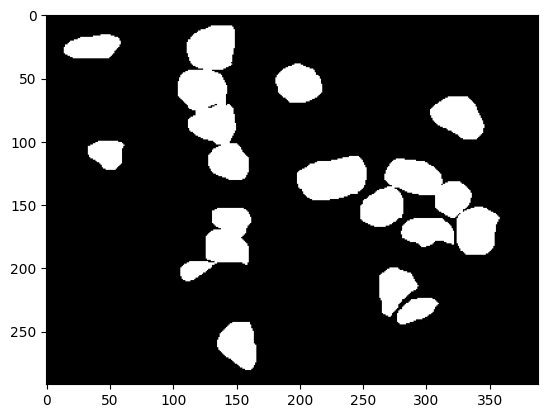

In [597]:
def draw_annotations(image: cv.Mat, annotations: List[AnnotationPoly]) -> cv.Mat:
    output = image.copy()
    for a in annotations:
        points = np.array([point for point in a.points], np.int32)
        output = cv.fillPoly(output, pts=[points], color=(255,255,255))
        plt.imshow(output)
    return output


train_im = dataset.train_images[0]
empty = train_im.resized.copy()
empty[:,:] = 0
im_with_annotations = draw_annotations(empty, train_im.resized_annotations)
plt.imshow(im_with_annotations)

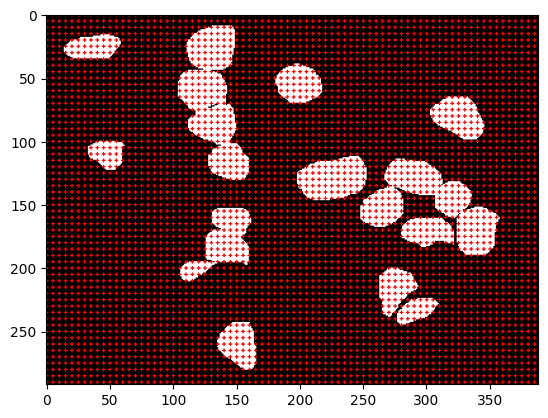

In [598]:
import math

PredictionGrid = Dict[Tuple[int,int],Tuple[int,int,float]]

def batched(iterable, batch_size=100):
    l = []
    for (i,e) in enumerate(iterable):
        l.append(e)
        if((i+1) % batch_size == 0):
            yield l
            l =[]
    if(len(l) > 0):
        yield l

def get_prediction_grid(model: Sequential, image: cv.Mat) -> PredictionGrid:
    """grid of (grid_i, grid_j) values that contains the actual pixel position (i,j) and the prediction as a float from 0.0-1.0
    """
    dic: PredictionGrid = dict()
    for batch in batched(convolution_frames(image)):
        frames = [f for (_,_,_,_,f) in batch]
        stacked_frames = tf.stack(frames)
        predictions = list(model.predict(stacked_frames)) # type: ignore # 
        for ((i,j,grid_i,grid_j,_),p) in zip(batch, predictions):
            dic[(grid_i,grid_j)]= (i,j,float(p))
    return dic

def filter_grid(prediction_grid: PredictionGrid, cutoff: float = 0.5) -> PredictionGrid:
    return { (grid_i,grid_j): (i,j,p) for ((grid_i,grid_j), (i,j,p)) in prediction_grid.items() if p >= cutoff }


def prediction_to_color(p):
    # c = (255-int(p*255)*2, 100, int(p*255) * 2)
    # p  = np.clip(p-0.5*2 + 1 ,0,1)
    p = 0.1 if p<0.5 else 1.0
    return (int(p*255),0,0)

def draw_prediction_grid(image: cv.Mat, grid: PredictionGrid):
    # draw a dot in the rescaled train_image for each element:
    output: cv.Mat = image.copy()
    output_dots_only: cv.Mat = image.copy()
    output_dots_only[:,:,:] = 0.0
    for ((grid_i,grid_j), (i,j,p)) in grid.items():
        color = prediction_to_color(p)
        cv.drawMarker(output,(int(j),int(i)), color=color, markerType=cv.MARKER_CROSS, 
        thickness=1, markerSize=int(PIXEL_GRID_SIZE / 2))
        # cv.drawMarker(output_dots_only,(int(j),int(i)), color=color, markerType=cv.MARKER_CROSS, 
        # thickness=1, markerSize=int(PIXEL_GRID_SIZE / 2))
    plt.imshow(output)
    plt.show()
    # plt.imshow(output_dots_only)
    # plt.show()

grid = get_prediction_grid(model, train_im.resized)
draw_prediction_grid(im_with_annotations, grid)


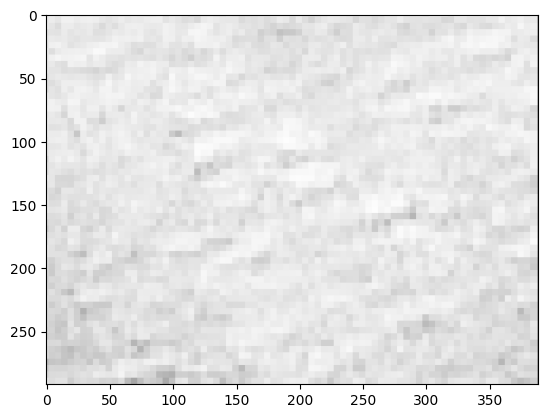

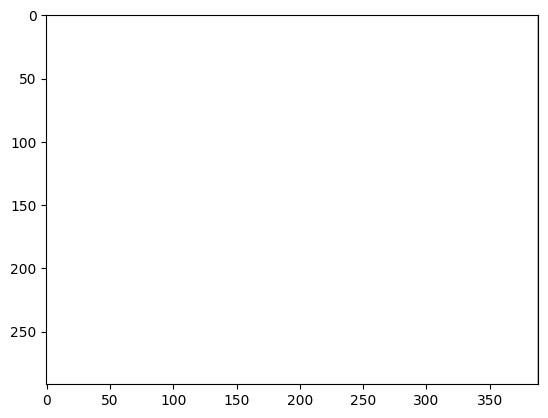

In [599]:
def prediction_grid_to_squares(grid: PredictionGrid) -> List[np.ndarray]:
    squares: List[np.ndarray] = []
    for ((grid_i,grid_j), (i,j,p)) in grid.items():
        points = np.array([(j-PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2),
        (j-PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),(j+PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),
        (j+PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2)], np.int32)
        # points = np.array([point for point in point_seq], )
        squares.append(points)
    return squares 

def draw_shapes_on_image(image: cv.Mat, polys: List[np.ndarray]) -> cv.Mat:
    output = image.copy()
    output = cv.fillPoly(output, pts=polys, color=(255,255,255))
    return output

def empty_copy(image: cv.Mat) -> cv.Mat:
    output = image.copy()
    output[:,:,:] = 0
    return output

def precision_grid_to_hard_image(reference_image_for_size: cv.Mat, grid: PredictionGrid, threshold=0.5):
    output = reference_image_for_size.copy()
    filtered_grid = filter_grid(grid, threshold) 
    squares: List[np.ndarray] = []
    for ((grid_i,grid_j), (i,j,p)) in filtered_grid.items():
        points = np.array([(j-PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2),
        (j-PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),(j+PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),
        (j+PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2)], np.int32)
        # points = np.array([point for point in point_seq], )
        squares.append(points)
    cv.fillPoly(output, pts=squares, color=(255,255,255))
    return output

def precision_grid_to_soft_image(reference_image_for_size: cv.Mat, grid: PredictionGrid):
    output = reference_image_for_size.copy()
    filtered_grid = filter_grid(grid) 
    for ((grid_i,grid_j), (i,j,p)) in filtered_grid.items():
        points = np.array([(j-PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2),
        (j-PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),(j+PIXEL_GRID_SIZE/2,i+PIXEL_GRID_SIZE/2),
        (j+PIXEL_GRID_SIZE/2,i-PIXEL_GRID_SIZE/2)], np.int32)
        # points = np.array([point for point in point_seq], )
        val = int(p*255)
        cv.fillPoly(output, pts=[points], color=(val,val,val))   
    return output


predicted_soft = precision_grid_to_soft_image(im_with_annotations, grid)
plt.imshow(predicted_soft)
plt.show()
predicted_hard = precision_grid_to_hard_image(im_with_annotations, grid)
plt.imshow(predicted_hard)
plt.show()

In [600]:
def confusion_from_images(original: cv.Mat, predicted: cv.Mat) -> Tuple[float,float,float,float]:
    """returns (tp,fp,tn,fn)
    original and predicted should be black white images
    """
    tp = np.where((original == 255) & (predicted == 255), 255, 0)
    fp = np.where((original != 255) & (predicted == 255), 255, 0)
    tn = np.where((original == 0) & (predicted == 0), 255, 0)
    fn = np.where((original != 0) & (predicted == 0), 255, 0)
    # a = (np.mean(tp) + np.mean(fp) + np.mean(tn) + np.mean(fn)) / 255 # this should be 1
    tp = float(np.mean(tp) / 255)
    fp = float(np.mean(fp) / 255)
    tn = float(np.mean(tn) / 255)
    fn = float(np.mean(fn) / 255)
    return (tp,fp,tn,fn)

def confusion_from_soft_images(original: cv.Mat, predicted_soft: cv.Mat, threshold: float):
    predicted = np.where(predicted_soft > (threshold * 255), 255, 0) # type: ignore
    return confusion_from_images(original, predicted)
    
confusion_from_soft_images(im_with_annotations, predicted_soft, threshold=0.2)

(0.1429200267633905, 0.8545092791492058, 0.0025706940874035992, 0.0)